<a href="https://colab.research.google.com/github/cuboid0223/Deep-Generative-Models/blob/main/VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from torchvision import datasets, transforms
from torchvision.datasets import FashionMNIST
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Hyperparameters
batch_size = 128
learning_rate = 0.01
num_epochs = 100

# Device configuration
device = 'mps' if torch.backends.mps.is_available() else 'cpu'

In [ ]:
train_dataset = FashionMNIST(root='data', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = FashionMNIST(root='data', train=False, transform=transforms.ToTensor(), download=True)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [ ]:
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=10, shuffle=False)

In [ ]:
# Variational Autoencoder
class VAE(nn.Module):
    def __init__(self, in_channels=784, hidden_1=256, hidden_2=256, in_decode_dim=2, hidden_3=256):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(in_channels, hidden_1)
        self.fc21 = nn.Linear(hidden_2, 2)
        self.fc22 = nn.Linear(hidden_2, 2)
        self.fc3 = nn.Linear(in_decode_dim, hidden_3)
        self.fc4 = nn.Linear(hidden_3, in_channels)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    # reparameterization trick
    def reparameterize(self, mu, logvar):
        """
        Reparameterization trick to sample from N(mu, var) from N(0,1)

        Args:
            mu: mean
            logvar: log variance

        Returns:
            z: latent vector
        """

        # log variance取平方根
        std = torch.exp(0.5*logvar)
        # 產生一個和std一樣大小的隨機數
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return self.fc4(h3)

    def forward(self, x):
        # flatten image to vector
        x = x.view(-1, 784)
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


In [ ]:
def loss_function(reconstruct_x, x, mu, logvar):
    """
    Loss function

    Args:
        reconstruct_x: reconstructed image
        x: original image
        mu: mean
        logvar: log variance

    Returns:
        loss: loss
    """
    # reconstruction loss
    MSELoss = nn.MSELoss(size_average=False)(reconstruct_x, x)
    # KL divergence
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return MSELoss * 0.5 + KLD

In [ ]:
def to_img(x):
    """
    Convert tensor to image

    Args:
        x: tensor

    Returns:
        img: image
    """
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    x = x.view(x.size(0), 1, 28, 28)
    return x


def imshow(img):
    """
    Show image

    Args:
        img: image
    """
    npimg = img.numpy()
    plt.axis("off")
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [ ]:
model = VAE().to(device)
model

VAE(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc21): Linear(in_features=256, out_features=2, bias=True)
  (fc22): Linear(in_features=256, out_features=2, bias=True)
  (fc3): Linear(in_features=2, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=784, bias=True)
)

In [ ]:
def train(model, train_loader, loss_fn, optimizer, n_epoch):
    model.train()
    train_loss = []
    for epoch in range(1, n_epoch + 1):
        epoch_loss = 0
        for batch_idx, (data, _) in enumerate(train_loader):
            data = data.view(data.size(0), -1).to(device)
            optimizer.zero_grad()
            reconstruct_x, mu, logvar = model(data)
            loss = loss_fn(reconstruct_x, data, mu, logvar)
            epoch_loss += loss.item()
            loss.backward()
            optimizer.step()

        print('Epoch: {:4d} \tLoss: {:.9f}'.format(epoch, epoch_loss))
        train_loss.append(epoch_loss)
        epoch_loss = 0
    return model, loss

In [ ]:

# Build the model
model = VAE().to(device)

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

model, train_loss = train(model, train_loader, loss_function, optimizer, num_epochs)

/Users/terry/miniforge3/envs/tf/lib/python3.9/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch:    1 	Loss: 1266148.448242188
Epoch:    2 	Loss: 1086159.798706055
Epoch:    3 	Loss: 1058391.723632812
Epoch:    4 	Loss: 1041923.791137695
Epoch:    5 	Loss: 1030719.375122070
Epoch:    6 	Loss: 1022074.223144531
Epoch:    7 	Loss: 1018538.601074219
Epoch:    8 	Loss: 1012612.911254883
Epoch:    9 	Loss: 1008704.941284180
Epoch:   10 	Loss: 1003457.258422852
Epoch:   11 	Loss: 1000894.757202148
Epoch:   12 	Loss: 998169.890258789
Epoch:   13 	Loss: 995079.355712891
Epoch:   14 	Loss: 994012.675781250
Epoch:   15 	Loss: 992445.730102539
Epoch:   16 	Loss: 989095.473754883
Epoch:   17 	Loss: 987710.942504883
Epoch:   18 	Loss: 985752.227539062
Epoch:   19 	Loss: 984170.394775391
Epoch:   20 	Loss: 982329.888549805
Epoch:   21 	Loss: 980609.208007812
Epoch:   22 	Loss: 979020.054077148
Epoch:   23 	Loss: 978109.173217773
Epoch:   24 	Loss: 977036.916748047
Epoch:   25 	Loss: 975763.735351562
Epoch:   26 	Loss: 975478.774658203
Epoch:   27 	Loss: 974643.055297852
Epoch:   28 	Loss

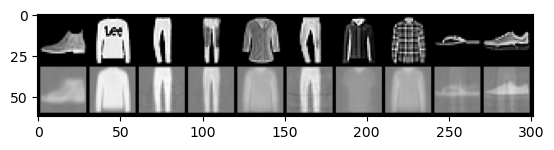

In [ ]:
samples = iter(test_loader)
images, labels = next(samples)
images = images.view(images.size(0), -1).to(device)
with torch.no_grad():
    pred, mu, logvar = model(images)
reconstruct_x = to_img(pred.cpu().data)
rel = torch.cat([images.view(-1, 1, 28, 28).cpu().data, reconstruct_x], dim=0)
imshow(make_grid(rel, nrow=10))

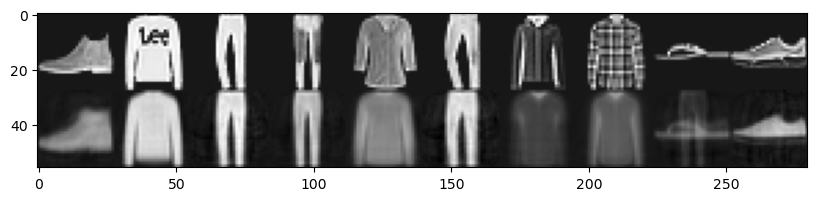

In [ ]:
# Test the model
model.eval()
with torch.no_grad():
    n = 10
    comparison = torch.zeros(2 * 28, n * 28)
    for i, (data, _) in enumerate(test_loader):
        data = data.to(device)
        recon, _, _ = model(data)
        for j in range(n):
            comparison[0 * 28:(0 + 1) * 28, j * 28:(j + 1) * 28] = data[j].view(28, 28)
            comparison[1 * 28:(1 + 1) * 28, j * 28:(j + 1) * 28] = recon[j].view(28, 28)
        break
    plt.figure(figsize=(n, 2))
    plt.imshow(comparison.cpu().numpy(), cmap='gray')
    plt.show()

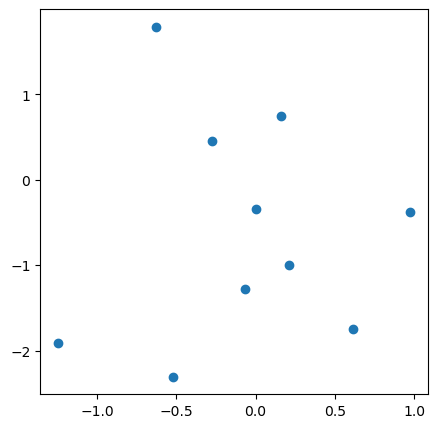

In [ ]:
samples = iter(test_loader)
images, labels = next(samples)
images = images.view(images.size(0), -1).to(device)
with torch.no_grad():
    mu, logvar = model.encode(images)
    z = model.reparameterize(mu, logvar)
    z = z.cpu().data.numpy()
    plt.figure(figsize=(5, 5))
    plt.scatter(z[:, 0], z[:, 1])
    plt.show()